# Proyecto final: "SIR generalizado para modelo epidemiológico".
### Cristóbal Ramos Suzuki, Leila Reyes Giménez
##### Profesor: Joaquín Fontbona
##### Profesor Auxiliar: Pablo Zúñiga



## Modelo SIR generalizado mediante simulación de Cadenas de Markov

In [1]:
import numpy as np
import random as random
import matplotlib.pyplot as plt

In [2]:
# Definimos la distribución exponencial:
def exp(lamda, N=1):
    u = np.random.uniform(0,1,N)
    exp = np.zeros(N)
    for i in range(N):
        exp[i] = -np.log(u[i])/lamda
    return exp

In [3]:
#Funciones para seleccionar a theta individuos según la distribución de theta.
def seleccionBin(P,parametro,K): 
    cantidad = np.random.binomial(K,parametro)
    if cantidad <= len(P):
        randomlist_bin = random.sample(P,cantidad)
        return randomlist_bin 
    else:
        return []

def seleccionPoiss(P,parametro): 
    cantidad = np.random.poisson(parametro)
    if cantidad <= len(P):
        randomlist_poiss = random.sample(P,cantidad)
        return randomlist_poiss
    else:
        return []

In [4]:
def SIR_Generalizado(N, deltat, T, p, pre_mu, pre_gamma, distr_theta, printear=False):

    #-----------------------PARÁMETROS--------------------#
    # Generales:
    mu = pre_mu*N   # tasa de reunion
    #-----------------------------------------------------#

    # Definimos la población (finita)
    P = []
    i_0 = int(0.01*N)
    for i in range(i_0):      # Estado inicial de población infectada
        P.append([i,'i'])
    for i in range(i_0,N):    # Estado inicial de población susceptible
        P.append([i, 's'])    
    
    # Definimos los conjuntos Suceptible, Infectado y Recuperado.
    # Sin pérdida de generalidad asumimos que primeros i_0 son poblacion infect inicial
    S = [P[i] for i in range(i_0,N)]
    I = [P[i] for i in range(i_0)]
    R = []

    # Creamos la cadena de markov que representará la proporción de la poblacion susceptible, infectada y recuperada del total.
    Ys = [len(S)/N]
    Yi = [len(I)/N]
    Yr = [len(R)/N]

    # Reloj exponencial para tasa de reunión:
    last_gath_time = 0
    gathering_time = exp(mu)[0]

    # Reloj exponencial para tasa de recuperación:
    gamma = pre_gamma*len(I)
    last_recup_time = 0
    recup_time = exp(gamma)[0]

    if printear == True:   # Para visualizar el estado inicial de la cadena.
        print("t = ", 0)
        print("len S_i = ", len(S))
        print("len I_i = ", len(I))
        print("len R_i = ", len(R)) 
        print("Estado inicial = ", [Ys[0], Yi[0], Yr[0]])
        print("--------------------")

    # Malla temporal en que simulamos la evolución de la cadena. 
    for t in np.arange(deltat,T,deltat):
        if (t - last_gath_time) < gathering_time:  # Aun no se genera una reunión.
            Ys.append(len(S)/N)
            Yi.append(len(I)/N)
            Yr.append(len(R)/N)            
        
        else:  # Creamos la reunión y actualizamos el estado de la cadena:
            last_gath_time += gathering_time # Actualizamos el tiempo de la última reunión .
            gathering_time = exp(mu)[0]      # Sampleamos el tiempo de la próxima reunión 
            
            # Generamos gathering M segun la distribución de theta:
            if distr_theta[0] == 'bin': M = seleccionBin(P,distr_theta[1],distr_theta[2])
            elif distr_theta[0] == 'poiss': M = seleccionPoiss(P,distr_theta[1])

            # Separamos a los individuas infectados y los susceptibles de la reunión:
            M_i = []
            M_s = []
            for ind in M:
                if ind[1] == "i":
                    M_i.append(ind)
                if ind[1] == "s":
                    M_s.append(ind)

            # Actualizamos a Infectadxs
            if len(M_s)>0:
                b = np.random.binomial(1,1-(1-p)**(len(M_i)), len(M_s))  # Sampleo de v.a. Bernoulli para idetificar nuevos infectados. 
                for j in range(len(M_s)):
                    if b[j] == 1:
                        i_infect = S.index(M_s[j])
                        S.pop(i_infect)              # Sacamos al nuevo infectado del cjto de susceptibles. 
                        new_infect = M_s[j]
                        new_infect[1] = "i"
                        I.append(new_infect)         # Agregamos al nuevo infectado al cjto de infectados. 

            #Actualizamos a Recuperadxs:
            gamma = pre_gamma*(len(I)) # Actualizamos el gamma según la cantidad de infectados actual. 
            recup_time = exp(gamma)[0] # Sampleamos el tiempo de recuperación. 
            if len(I)>0:
                recups = 0   # Contamos la cantidad de individuos que se recuperarán. 
                while ((t - last_recup_time) >= recup_time) and (recups < len(I)):  # Tiempo transcurrido supera al tiempo de recuperación. 
                    recups += 1
                    last_recup_time += recup_time
                    gamma = pre_gamma*(len(I)-recups) # Actualizamos el gamma según la cantidad de infectados actual.
                    recup_time = exp(gamma)[0]        # Sampleamos el próximo tiempo de recuperación.

                for i in range(recups):
                    r = I.pop(0)        # Removemos a los recuperados del cjto de infectados,
                    R.append(r)         # y los agregamos al cjto de recuperados. 

            # Registramos el estado de la cadena de Markov en el tiempo t:
            Ys.append(len(S)/N)   
            Yi.append(len(I)/N)
            Yr.append(len(R)/N)

    if printear == True:     # Para visualizar el estado final de la cadena.
        print("t_f = ", t)
        print("len S_f = ", len(S))
        print("len I_f = ", len(I))
        print("len R_f = ", len(R))
        print("Estado final = ", [Ys[-1], Yi[-1], Yr[-1]])
        print("--------------------")

    # Creamos malla temporal para graficar la cadena según los parámetros:
    ejeX = np.arange(0,T,deltat)

    return [Ys, Yi, Yr], ejeX

In [5]:
# Desde ahora consideraremos los siguientes valores de N y deltat
N = 10000
deltat = 0.0001

### Consideraremos dos distribuciones para $\Theta$, Binomial (A) y Poisson (B), con sus respectivos parámetros.




#### A) $ \Theta \sim Bin(K, k)$

##### 1. $K=20, k=0.1 \Longrightarrow \mathbb{E}(\Theta) = 2$ 

In [6]:
# Parámetros distribucion de theta
Distr_bin1 = ["bin", 0.1, 20]

# Simulación CM
Z_bin1, ejeX = SIR_Generalizado(N, deltat, T=100, p=0.2, pre_mu=0.5, pre_gamma=0.1, distr_theta=Distr_bin1)

C:\Users\nico_\AppData\Local\Temp\ipykernel_4688\1079300851.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  exp[i] = -np.log(u[i])/lamda


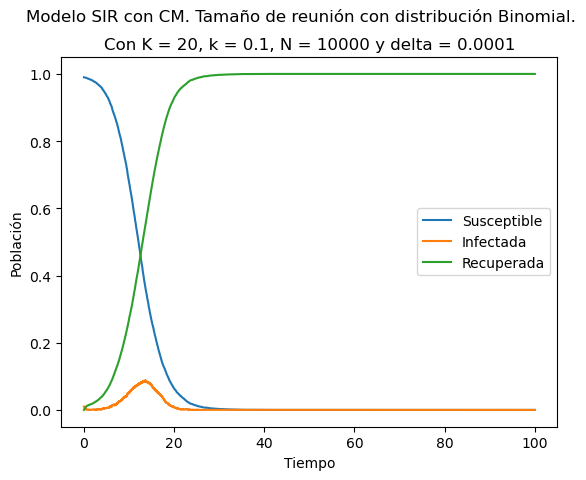

In [7]:
plt.figure()
plt.suptitle('Modelo SIR con CM. Tamaño de reunión con distribución Binomial.')
plt.title('Con K = ' +str(Distr_bin1[2])+", k = "+str(Distr_bin1[1]) + ', N = '+str(N)+ ' y delta = '+ str(deltat) )
plt.plot(ejeX,Z_bin1[0], label = "Susceptible")
plt.plot(ejeX,Z_bin1[1], label = "Infectada")
plt.plot(ejeX,Z_bin1[2], label = "Recuperada")
plt.xlabel('Tiempo')
plt.ylabel('Población')
plt.legend()

##### 2) $K=20, k=0.2 \Longrightarrow \mathbb{E}(\Theta) = 4$ 

In [8]:
# Parámetros distribucion de theta
Distr_bin2 = ["bin", 0.2, 20]

# Simulación CM
Z_bin2, ejeX = SIR_Generalizado(N, deltat, T=100, p=0.2, pre_mu=0.5, pre_gamma=0.1, distr_theta=Distr_bin2)

C:\Users\nico_\AppData\Local\Temp\ipykernel_4688\1079300851.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  exp[i] = -np.log(u[i])/lamda


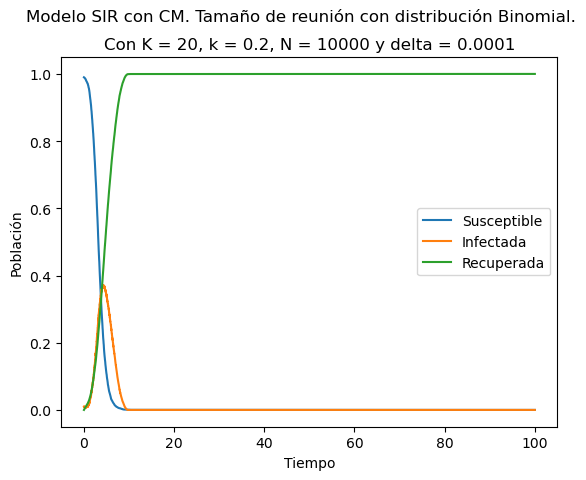

In [9]:
plt.figure()
plt.suptitle('Modelo SIR con CM. Tamaño de reunión con distribución Binomial.')
plt.title('Con K = ' +str(Distr_bin2[2])+", k = "+str(Distr_bin2[1]) + ', N = '+str(N)+ ' y delta = '+ str(deltat) )
plt.plot(ejeX,Z_bin2[0], label = "Susceptible")
plt.plot(ejeX,Z_bin2[1], label = "Infectada")
plt.plot(ejeX,Z_bin2[2], label = "Recuperada")
plt.xlabel('Tiempo')
plt.ylabel('Población')
plt.legend()

##### 3) $K=20, k=0.3 \Longrightarrow \mathbb{E}(\Theta) = 6$ 

In [10]:
# Parámetros distribucion de theta
Distr_bin3 = ["bin", 0.3, 20]

# Simulación CM
Z_bin3, ejeX = SIR_Generalizado(N, deltat, T=100, p=0.2, pre_mu=0.5, pre_gamma=0.1, distr_theta=Distr_bin3)

C:\Users\nico_\AppData\Local\Temp\ipykernel_4688\1079300851.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  exp[i] = -np.log(u[i])/lamda


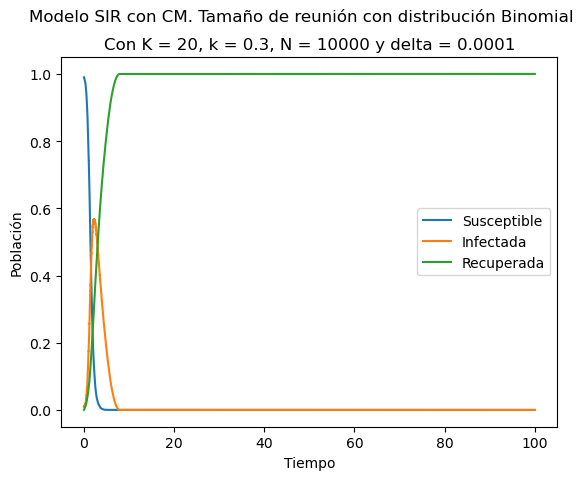

In [11]:
plt.figure()
plt.suptitle("Modelo SIR con CM. Tamaño de reunión con distribución Binomial")
plt.title('Con K = ' +str(Distr_bin3[2])+", k = "+str(Distr_bin3[1]) + ', N = '+str(N)+ ' y delta = '+ str(deltat) )
plt.plot(ejeX,Z_bin3[0], label = "Susceptible")
plt.plot(ejeX,Z_bin3[1], label = "Infectada")
plt.plot(ejeX,Z_bin3[2], label = "Recuperada")
plt.xlabel('Tiempo')
plt.ylabel('Población')
plt.legend()

#### Comparación de distintos parámetros para distribución binomial.

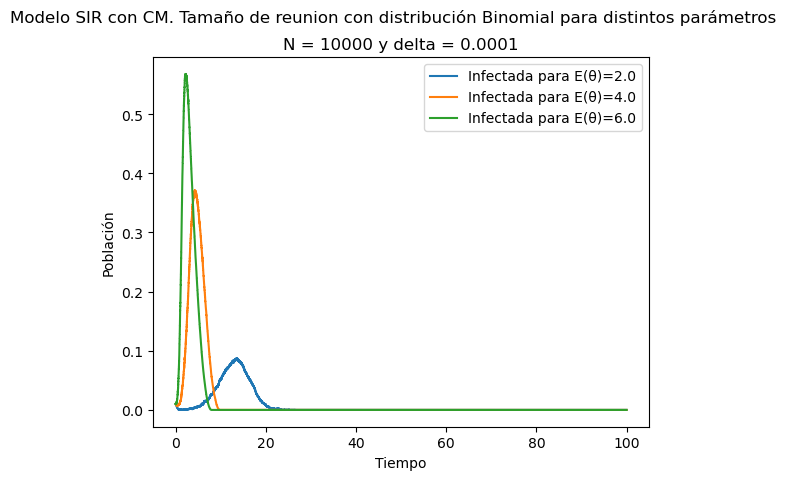

In [12]:
plt.figure()
plt.suptitle('Modelo SIR con CM. Tamaño de reunion con distribución Binomial para distintos parámetros')
plt.title('N = '+str(N)+ ' y delta = '+ str(deltat) )
plt.plot(ejeX,Z_bin1[1], label = "Infectada para E(θ)="+str(Distr_bin1[1]*Distr_bin1[2]))
plt.plot(ejeX,Z_bin2[1], label = "Infectada para E(θ)="+str(Distr_bin2[1]*Distr_bin2[2]))
plt.plot(ejeX,Z_bin3[1], label = "Infectada para E(θ)="+str(Distr_bin3[1]*Distr_bin3[2]))
plt.xlabel('Tiempo')
plt.ylabel('Población')
plt.legend()

#### B) $\Theta \sim Poiss(\lambda)$


#####  $ 1) $   $\lambda = 2 \Longrightarrow \mathbb{E}(\Theta) = 2$

In [13]:
# Parámetros distribucion de theta
Distr_poiss1 = ["poiss", 2]

# Simulación CM
Z_poiss1, ejeX = SIR_Generalizado(N, deltat, T=100, p=0.2, pre_mu=0.5, pre_gamma=0.1, distr_theta=Distr_poiss1)

C:\Users\nico_\AppData\Local\Temp\ipykernel_4688\1079300851.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  exp[i] = -np.log(u[i])/lamda


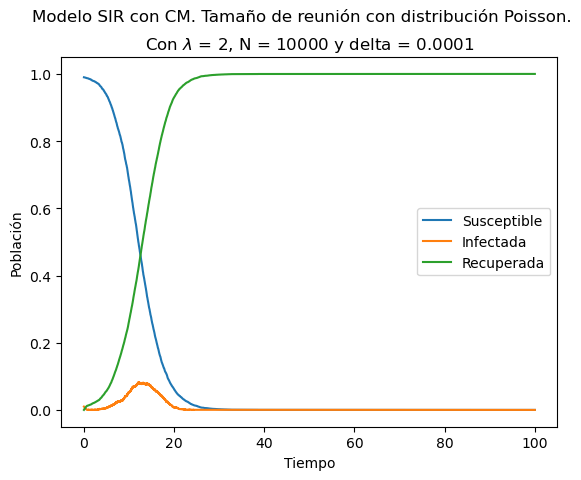

In [14]:
plt.figure()
plt.suptitle('Modelo SIR con CM. Tamaño de reunión con distribución Poisson.')
plt.title('Con $\lambda$ = ' +str(Distr_poiss1[1]) + ', N = '+str(N)+ ' y delta = '+ str(deltat))
plt.plot(ejeX,Z_poiss1[0], label="Susceptible")
plt.plot(ejeX,Z_poiss1[1], label="Infectada")
plt.plot(ejeX,Z_poiss1[2], label="Recuperada")
plt.xlabel('Tiempo')
plt.ylabel('Población')
plt.legend()

##### $ 2) $   $\lambda = 4 \Longrightarrow \mathbb{E}(\Theta) = 4$

In [15]:
# Parámetros distribucion de theta
Distr_poiss2 = ["poiss", 4]

# Simulación CM
Z_poiss2, ejeX = SIR_Generalizado(N, deltat, T=100, p=0.2, pre_mu=0.5, pre_gamma=0.1, distr_theta=Distr_poiss2)

C:\Users\nico_\AppData\Local\Temp\ipykernel_4688\1079300851.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  exp[i] = -np.log(u[i])/lamda


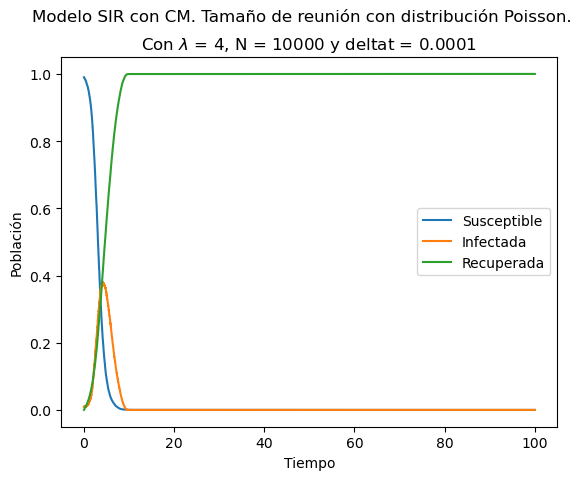

In [16]:
plt.figure()
plt.suptitle('Modelo SIR con CM. Tamaño de reunión con distribución Poisson.')
plt.title('Con $\lambda$ = '+ str(Distr_poiss2[1]) + ', N = ' + str(N)+ ' y deltat = '+ str(deltat))
plt.plot(ejeX,Z_poiss2[0], label="Susceptible")
plt.plot(ejeX,Z_poiss2[1], label="Infectada")
plt.plot(ejeX,Z_poiss2[2], label="Recuperada")
plt.xlabel('Tiempo')
plt.ylabel('Población')
plt.legend()

##### $ 3) $   $\lambda = 6 \Longrightarrow \mathbb{E}(\Theta) = 6$

In [17]:
# Parámetros distribucion de theta
Distr_poiss3 = ["poiss", 6]

# Simulación CM
Z_poiss3, ejeX = SIR_Generalizado(N, deltat, T=100, p=0.2, pre_mu=0.5, pre_gamma=0.1, distr_theta=Distr_poiss3)

C:\Users\nico_\AppData\Local\Temp\ipykernel_4688\1079300851.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  exp[i] = -np.log(u[i])/lamda


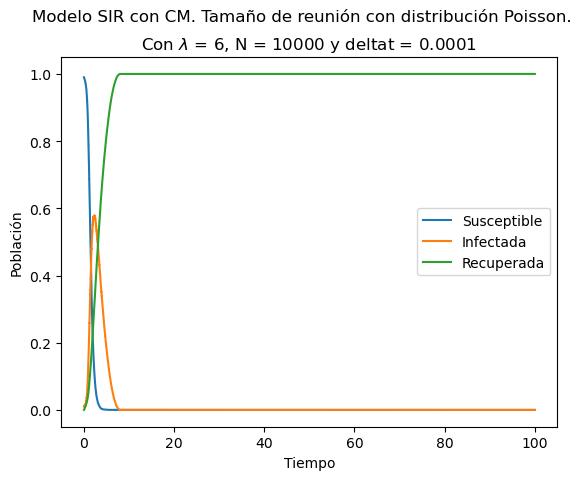

In [18]:
plt.figure()
plt.suptitle('Modelo SIR con CM. Tamaño de reunión con distribución Poisson.')
plt.title('Con $\lambda$ = '+ str(Distr_poiss3[1]) + ', N = '+ str(N)+ ' y deltat = '+ str(deltat))
plt.plot(ejeX,Z_poiss3[0], label="Susceptible")
plt.plot(ejeX,Z_poiss3[1], label="Infectada")
plt.plot(ejeX,Z_poiss3[2], label="Recuperada")
plt.xlabel('Tiempo')
plt.ylabel('Población')
plt.legend()

#### Comparación de distintos parámetros para distribución Poisson

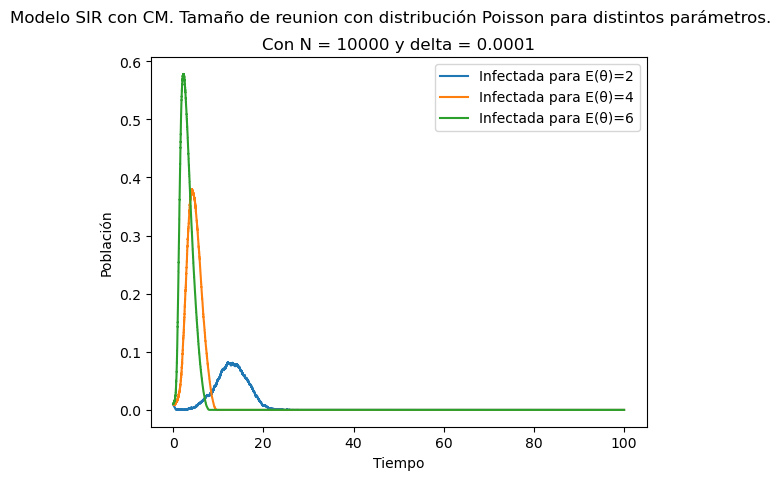

In [19]:
plt.figure()
plt.suptitle('Modelo SIR con CM. Tamaño de reunion con distribución Poisson para distintos parámetros.')
plt.title('Con N = '+str(N)+ ' y delta = '+ str(deltat))
plt.plot(ejeX,Z_poiss1[1], label = "Infectada para E(θ)="+str(Distr_poiss1[1]))
plt.plot(ejeX,Z_poiss2[1], label = "Infectada para E(θ)="+str(Distr_poiss2[1]))
plt.plot(ejeX,Z_poiss3[1], label = "Infectada para E(θ)="+str(Distr_poiss3[1]))
plt.xlabel('Tiempo')
plt.ylabel('Población')
plt.legend()

### Veamos ahora una gráfico del modelo SIR con $\theta \sim Poiss(\lambda)$ donde $\lambda = 4$, sólo considerando la curva de infectados, variando el tamaño de delta_t.

In [20]:
# Grafiquemos para un N fijo y distintos valores de deltat
Nt = 4000
list_deltat = [0.01,0.05,0.003,0.007,0.0001]
Distr_poiss = ["poiss", 4]

C:\Users\nico_\AppData\Local\Temp\ipykernel_4688\1079300851.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  exp[i] = -np.log(u[i])/lamda


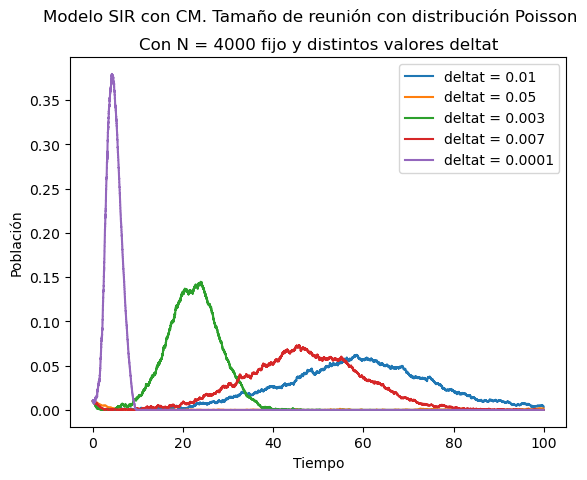

In [21]:
# Simulación CM
plt.figure()
for i in list_deltat:
    Z_poiss, ejeX = SIR_Generalizado(Nt,i, T=100, p=0.2, pre_mu=0.5, pre_gamma=0.1, distr_theta=Distr_poiss)
    plt.plot(ejeX,Z_poiss[1],label = 'deltat = '+ 
    str(i))
plt.suptitle('Modelo SIR con CM. Tamaño de reunión con distribución Poisson')
plt.title('Con N = '+ str(Nt)+ ' fijo y distintos valores deltat')
plt.xlabel('Tiempo')    
plt.ylabel('Población')
plt.legend()


## Sistema de Edo's para modelo SIR generalizado

In [22]:
import scipy as sc
from scipy.integrate import*

In [23]:
#Sistema de EDO's Binomial
def sistemaBin(sol,tiempo,u):
    #Parámetros
    mu = 0.5
    p = 0.2
    gamma = 0.1
    K_bin = 20
    k_bin = 0.2

    s = sol[0]
    i = sol[1]
    r = sol[2]
    aux1 = (-mu) * K_bin * k_bin * s * (1 - (1 - k_bin*p*i)**(K_bin-1))   # EDO s'
    aux2 = mu * K_bin * k_bin * s * (1 - (1 - k_bin*p*i)**(K_bin-1))  -  gamma * i  #EDO i'
    aux3 = gamma * i    #EDO r'
    aux4 = [aux1,aux2,aux3]
    return aux4

In [24]:
#Sistema de EDO's Poisson
def sistemaPoiss(sol,tiempo,u):
    #Parámetros
    mu = 0.5
    p = 0.2
    gamma = 0.1
    k_poiss = 4

    s = sol[0]
    i = sol[1]
    r = sol[2]
    aux1 = (-mu) * k_poiss * s * (1 - np.exp(-k_poiss*p*i))  # EDO s'
    aux2 = mu * k_poiss * s * (1 - np.exp(-k_poiss*p*i))  -  gamma * i  #EDO i'
    aux3 = gamma * i    #EDO r'
    aux4 = [aux1,aux2,aux3]
    return aux4

In [25]:
def Sol_edos(sistema, sist0, deltat, T):
    
    tiempo = np.linspace(0,T,int(T/deltat))

    u = np.zeros(len(tiempo))
    s = np.empty_like(tiempo)
    i = np.empty_like(tiempo)
    r = np.empty_like(tiempo)

    s[0] = sist0[0]
    i[0] = sist0[1]
    r[0] = sist0[2]

    for j in range(1,len(tiempo)):
        pasos = [tiempo[j-1],tiempo[j]]
        sol = sc.integrate.odeint(sistemaBin,sist0,pasos,args = (u[j],))
        s[j] = sol[1][0]
        i[j] = sol[1][1]
        r[j] = sol[1][2]
        sist0 = sol[1]

    return [s,i,r], tiempo


In [26]:
#Condiciones iniciales
s0 = 0.99
i0 = 0.01
r0 = 0
sist0 = [s0,i0,r0]

In [27]:
deltat = 0.0001
Sol_EDOs_bin, tiempo = Sol_edos(sistemaBin, sist0, deltat, T=100)

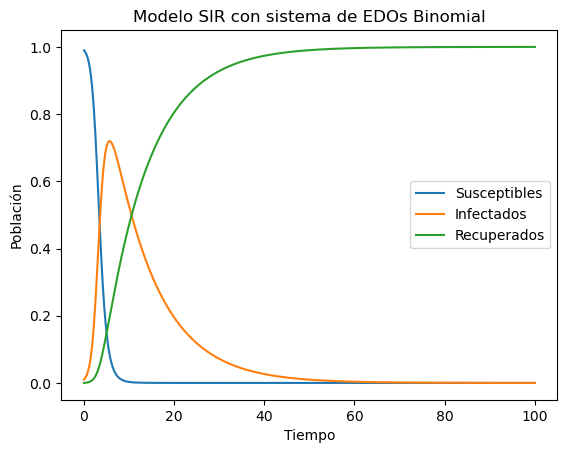

In [28]:
plt.figure()
plt.title('Modelo SIR con sistema de EDOs Binomial')
plt.plot(tiempo,Sol_EDOs_bin[0],label='Susceptibles')
plt.plot(tiempo,Sol_EDOs_bin[1],label='Infectados')
plt.plot(tiempo,Sol_EDOs_bin[2],label='Recuperados')
plt.xlabel('Tiempo')
plt.ylabel('Población')
plt.xlabel('Tiempo')
plt.ylabel('Población')
plt.legend()

In [29]:
deltat = 0.0001
Sol_EDOs_poiss, tiempo = Sol_edos(sistemaPoiss, sist0, deltat, T=100)

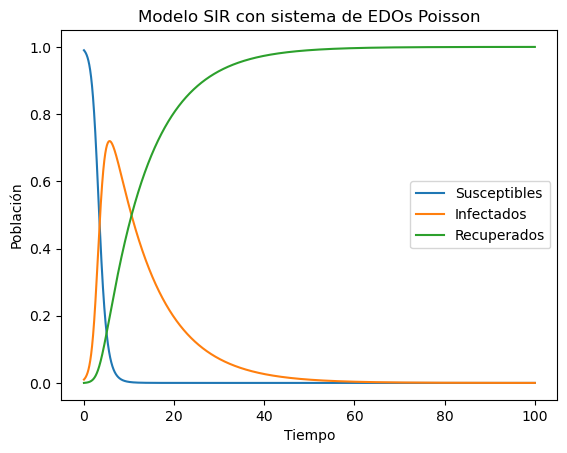

In [30]:
plt.figure()
plt.title('Modelo SIR con sistema de EDOs Poisson')
plt.plot(tiempo,Sol_EDOs_poiss[0],label='Susceptibles')
plt.plot(tiempo,Sol_EDOs_poiss[1],label='Infectados')
plt.plot(tiempo,Sol_EDOs_poiss[2],label='Recuperados')
plt.xlabel('Tiempo')
plt.ylabel('Población')
plt.legend()

## Convergencia del proceso de Markov a la solución del sistema de EDO's. 

##### Para $\Theta$ ~ Bin(20,0.2)

In [31]:
# Utilizamos Distr_bin2 que tiene E(theta)=4
N_list = [100, 500, 1000, 5000, 10000, 50000]
deltat_list = [1/i for i in N_list]
ZBin_list = []
SolBin_list = []
tiempo_list = []

for i in range(len(N_list)):
    Z_bin_Ni, ejeX_Ni = SIR_Generalizado(N_list[i], deltat_list[i], T=100, p=0.2, pre_mu=0.5, pre_gamma=0.1, distr_theta=Distr_bin2)
    Sol_EDOs_bin_Ni, tiempo_Ni = Sol_edos(sistemaBin, sist0, deltat_list[i], T=100)
    ZBin_list.append(Z_bin_Ni)
    SolBin_list.append(Sol_EDOs_bin_Ni)
    tiempo_list.append(tiempo_Ni)


C:\Users\nico_\AppData\Local\Temp\ipykernel_4688\1079300851.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  exp[i] = -np.log(u[i])/lamda


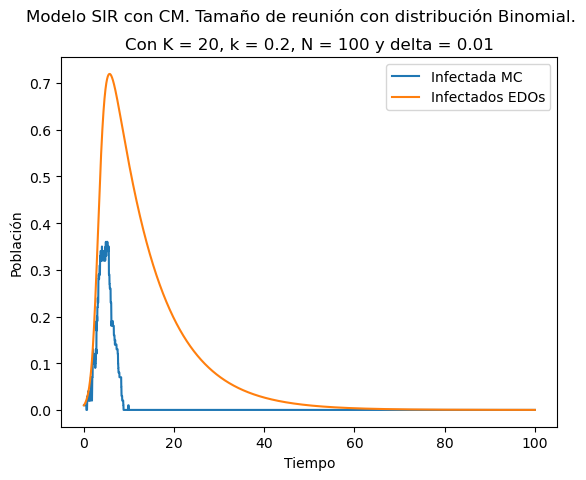

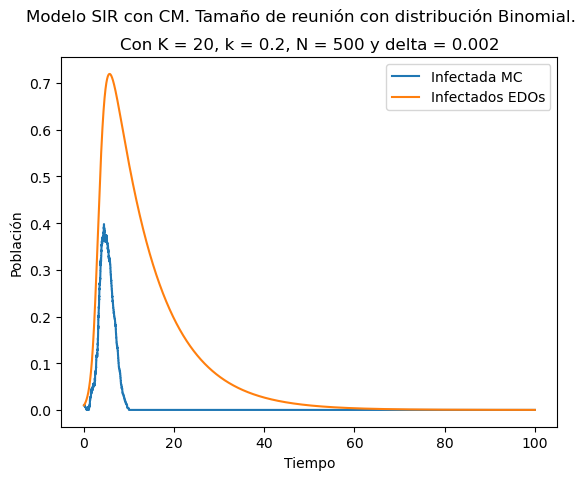

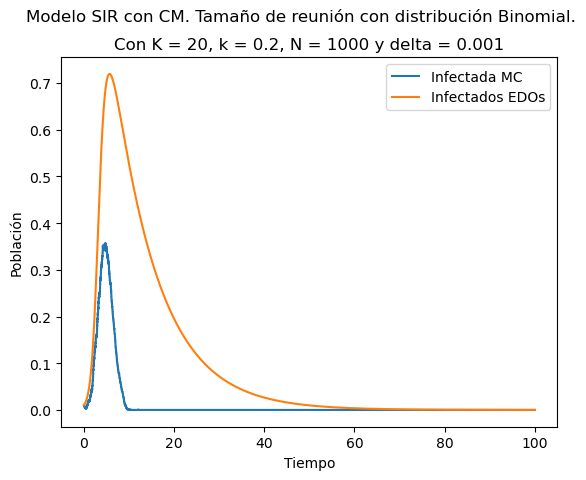

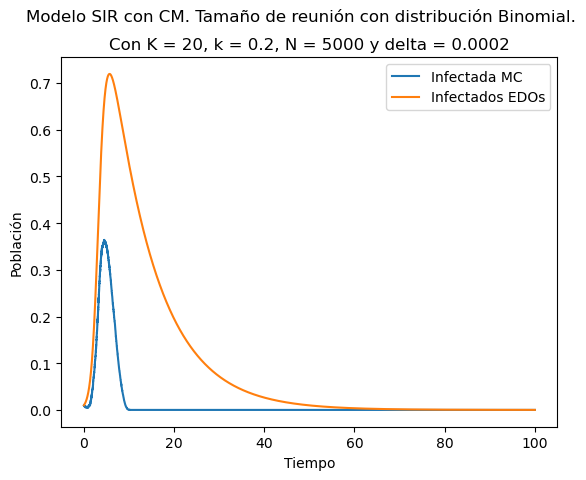

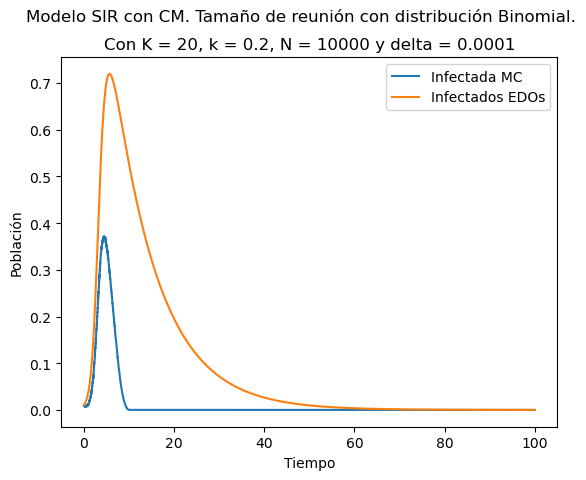

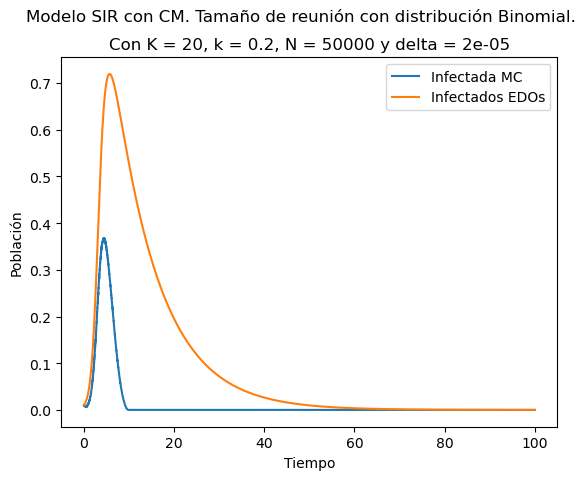

In [32]:
for i in range(len(N_list)):
    plt.figure()
    plt.suptitle('Modelo SIR con CM. Tamaño de reunión con distribución Binomial.')
    plt.title('Con K = ' +str(Distr_bin2[2])+", k = "+str(Distr_bin2[1]) + ', N = '+str(N_list[i])+ ' y delta = '+ str(deltat_list[i]))
    plt.plot(tiempo_list[i],ZBin_list[i][1], label = "Infectada MC")
    plt.plot(tiempo_list[i],SolBin_list[i][1],label='Infectados EDOs')
    plt.xlabel('Tiempo')
    plt.ylabel('Población')
    plt.legend()

##### Para $\Theta$ ~ Poiss(4)

In [33]:
# Utilizamos Distr_poiss2 que tiene E(theta)=4
N_list = [100, 500, 1000, 5000, 10000, 50000]
deltat_list = [1/i for i in N_list]
ZPoiss_list = []
SolPoiss_list = []
tiempo_list = []

for i in range(len(N_list)):
    Z_Poiss_Ni, ejeX_Ni = SIR_Generalizado(N_list[i], deltat_list[i], T=100, p=0.2, pre_mu=0.5, pre_gamma=0.1, distr_theta=Distr_poiss2)
    Sol_EDOs_Poiss_Ni, tiempo_Ni = Sol_edos(sistemaBin, sist0, deltat_list[i], T=100)
    ZPoiss_list.append(Z_Poiss_Ni)
    SolPoiss_list.append(Sol_EDOs_Poiss_Ni)
    tiempo_list.append(tiempo_Ni)

C:\Users\nico_\AppData\Local\Temp\ipykernel_4688\1079300851.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  exp[i] = -np.log(u[i])/lamda


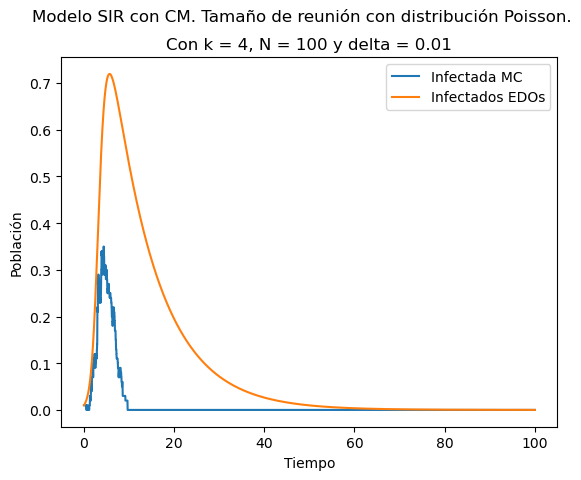

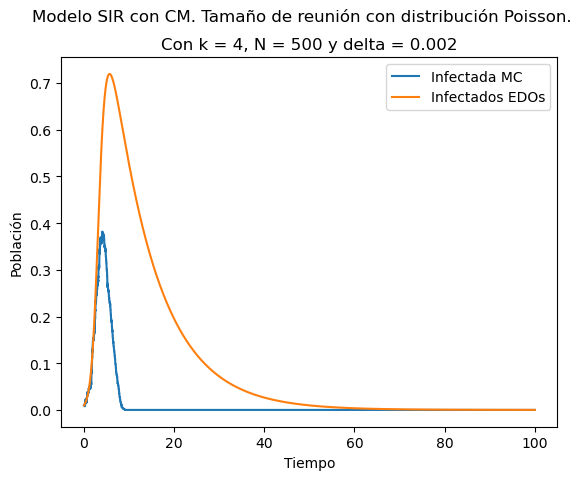

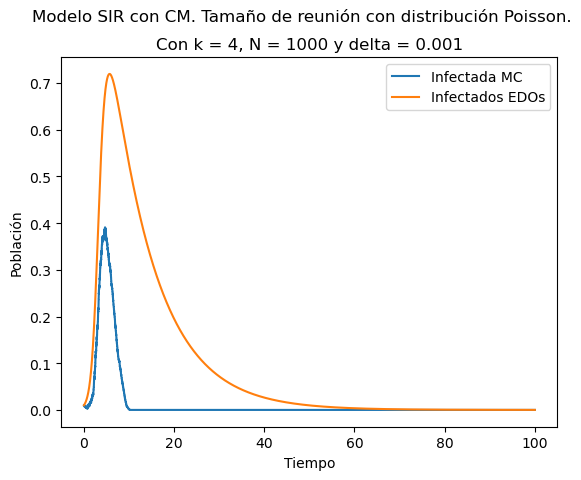

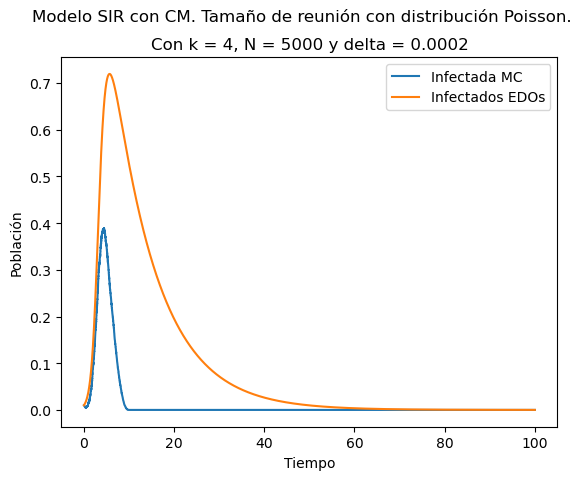

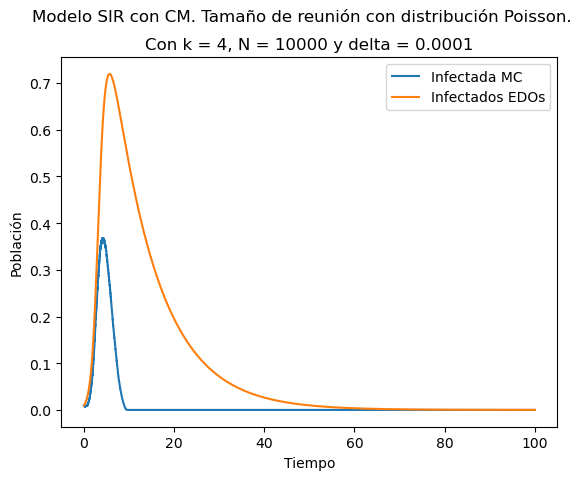

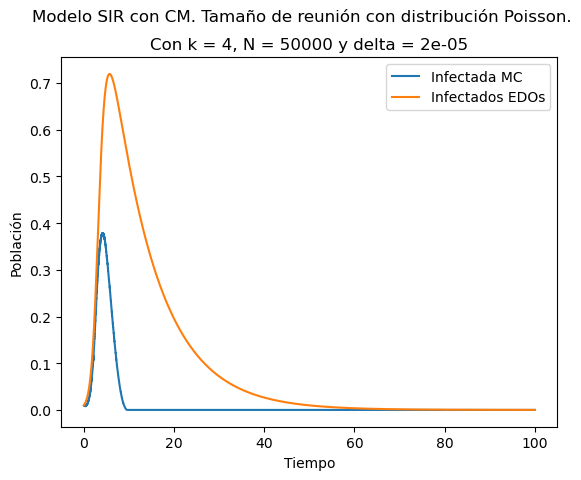

In [34]:
for i in range(len(N_list)):
    plt.figure()
    plt.suptitle('Modelo SIR con CM. Tamaño de reunión con distribución Poisson.')
    plt.title('Con k = '+str(Distr_poiss2[1]) + ', N = '+str(N_list[i])+ ' y delta = '+ str(deltat_list[i]))
    plt.plot(tiempo_list[i],ZPoiss_list[i][1], label = "Infectada MC")
    plt.plot(tiempo_list[i],SolPoiss_list[i][1],label='Infectados EDOs')
    plt.xlabel('Tiempo')
    plt.ylabel('Población')
    plt.legend()

### Veamos la convergencia de la cadena con $\Theta$~Bin(20,0.2), con deltat = cte. 

##### deltat = 0.1

In [35]:
# Utilizamos Distr_bin2 que tiene E(theta)=4
N_list = [100, 500, 1000, 5000, 10000]
deltat2 = 0.1
ZBin_list2 = []
SolBin_list2 = []
tiempo_list2 = []

for i in range(len(N_list)):
    Z_bin_Ni2, ejeX_Ni = SIR_Generalizado(N_list[i], deltat2, T=100, p=0.2, pre_mu=0.5, pre_gamma=0.1, distr_theta=Distr_bin2)
    Sol_EDOs_bin_Ni2, tiempo_Ni = Sol_edos(sistemaBin, sist0, deltat2, T=100)
    ZBin_list2.append(Z_bin_Ni2)
    SolBin_list2.append(Sol_EDOs_bin_Ni2)
    tiempo_list2.append(tiempo_Ni)

C:\Users\nico_\AppData\Local\Temp\ipykernel_4688\1079300851.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  exp[i] = -np.log(u[i])/lamda


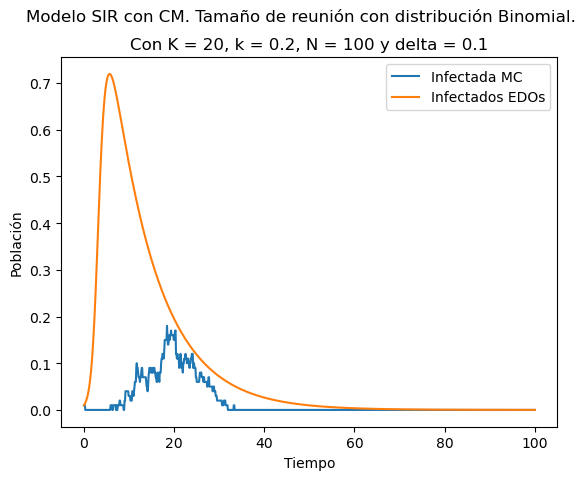

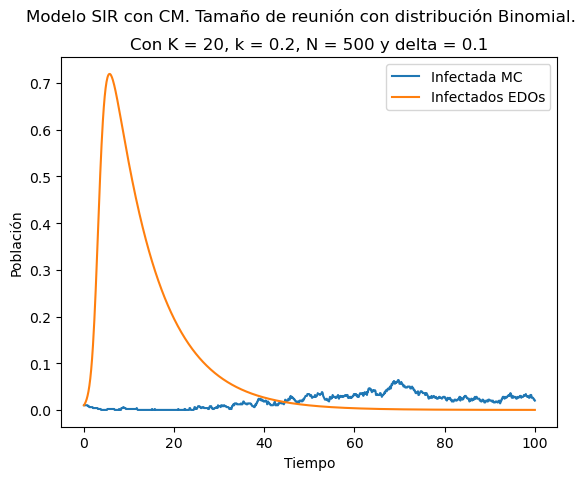

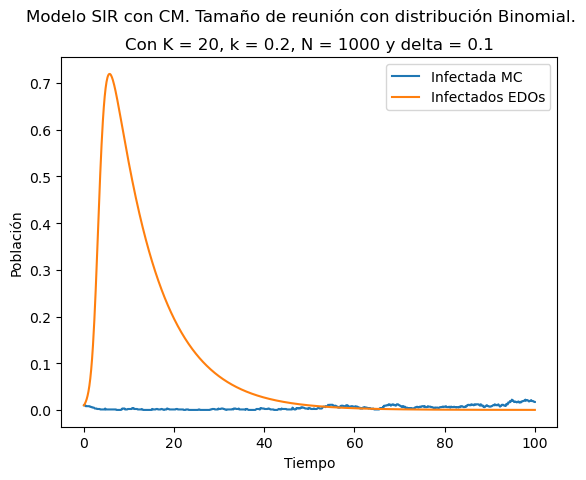

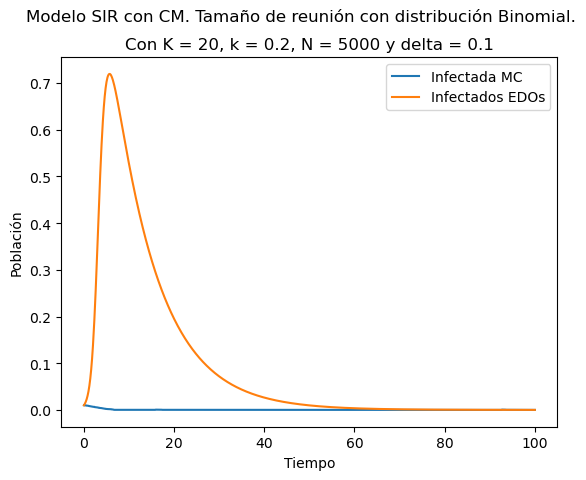

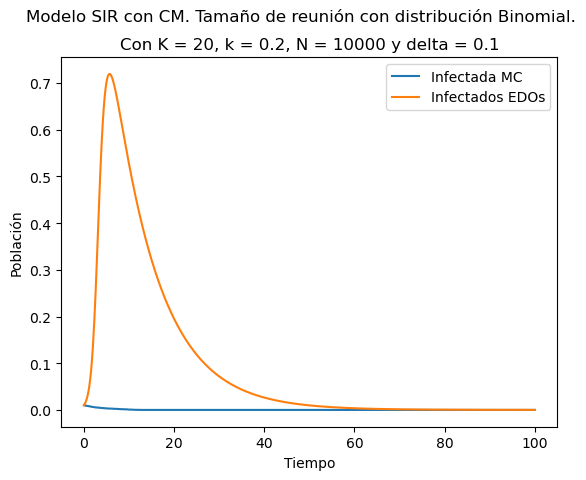

In [36]:
for i in range(len(N_list)):
    plt.figure()
    plt.suptitle('Modelo SIR con CM. Tamaño de reunión con distribución Binomial.')
    plt.title('Con K = ' +str(Distr_bin2[2])+", k = "+str(Distr_bin2[1]) + ', N = '+str(N_list[i])+ ' y delta = '+ str(deltat2))
    plt.plot(tiempo_list2[i],ZBin_list2[i][1], label = "Infectada MC")
    plt.plot(tiempo_list2[i],SolBin_list2[i][1],label='Infectados EDOs')
    plt.xlabel('Tiempo')
    plt.ylabel('Población')
    plt.legend()

##### deltat=0.01

In [37]:
# Utilizamos Distr_bin2 que tiene E(theta)=4
N_list = [100, 500, 1000, 5000, 10000]
deltat3 = 0.01
ZBin_list3 = []
SolBin_list3 = []
tiempo_list3 = []

for i in range(len(N_list)):
    Z_bin_Ni3, ejeX_Ni = SIR_Generalizado(N_list[i], deltat3, T=100, p=0.2, pre_mu=0.5, pre_gamma=0.1, distr_theta=Distr_bin2)
    Sol_EDOs_bin_Ni3, tiempo_Ni = Sol_edos(sistemaBin, sist0, deltat3, T=100)
    ZBin_list3.append(Z_bin_Ni3)
    SolBin_list3.append(Sol_EDOs_bin_Ni3)
    tiempo_list3.append(tiempo_Ni)

C:\Users\nico_\AppData\Local\Temp\ipykernel_4688\1079300851.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  exp[i] = -np.log(u[i])/lamda


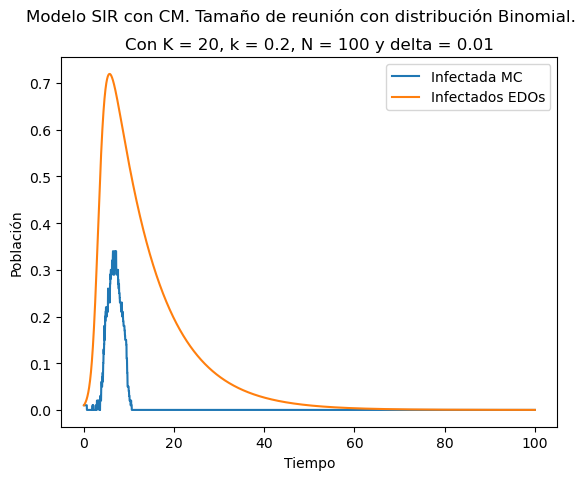

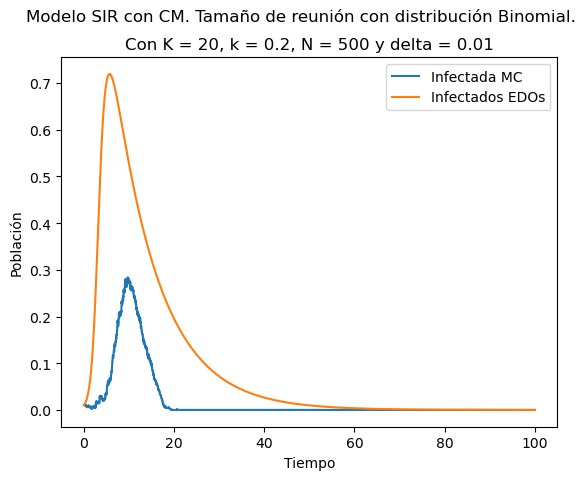

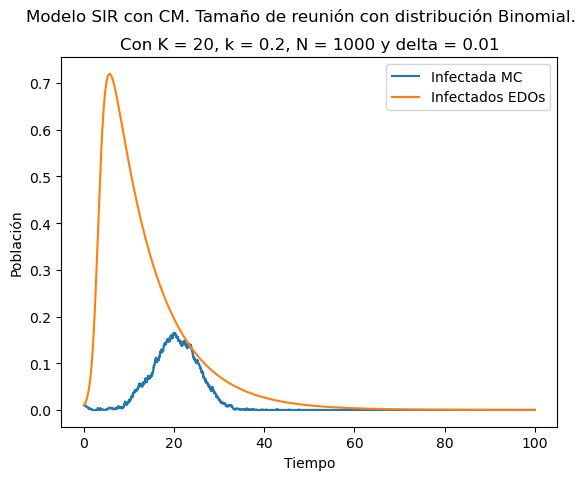

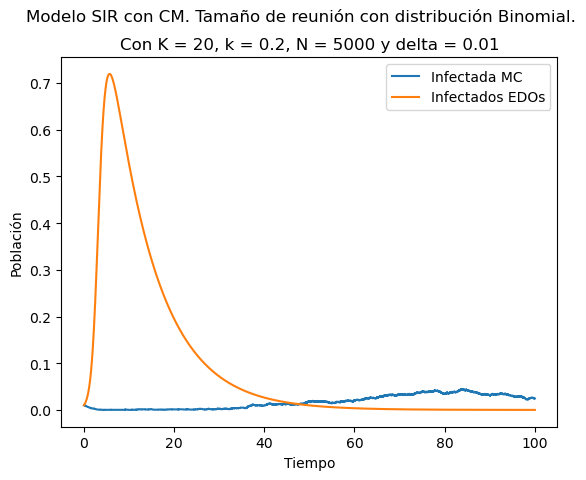

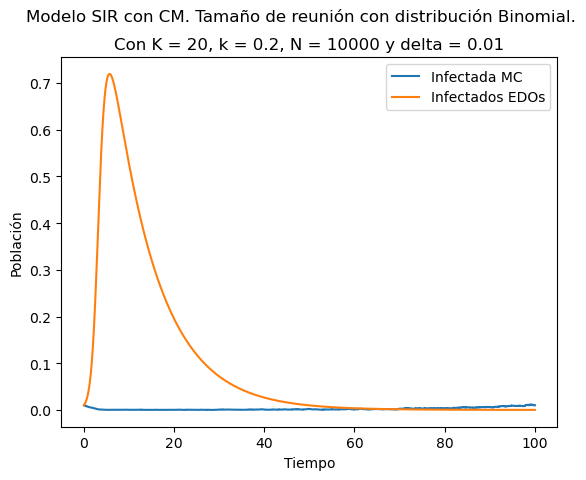

In [38]:
for i in range(len(N_list)):
    plt.figure()
    plt.suptitle('Modelo SIR con CM. Tamaño de reunión con distribución Binomial.')
    plt.title('Con K = ' +str(Distr_bin2[2])+", k = "+str(Distr_bin2[1]) + ', N = '+str(N_list[i])+ ' y delta = '+ str(deltat3))
    plt.plot(tiempo_list3[i],ZBin_list3[i][1], label = "Infectada MC")
    plt.plot(tiempo_list3[i],SolBin_list3[i][1],label='Infectados EDOs')
    plt.xlabel('Tiempo')
    plt.ylabel('Población')
    plt.legend()

##### deltat=0.001

In [39]:
# Utilizamos Distr_bin2 que tiene E(theta)=4
N_list = [100, 500, 1000, 5000, 10000]
deltat4 = 0.001
ZBin_list4 = []
SolBin_list4 = []
tiempo_list4 = []

for i in range(len(N_list)):
    Z_bin_Ni4, ejeX_Ni = SIR_Generalizado(N_list[i], deltat4, T=100, p=0.2, pre_mu=0.5, pre_gamma=0.1, distr_theta=Distr_bin2)
    Sol_EDOs_bin_Ni4, tiempo_Ni = Sol_edos(sistemaBin, sist0, deltat4, T=100)
    ZBin_list4.append(Z_bin_Ni4)
    SolBin_list4.append(Sol_EDOs_bin_Ni4)
    tiempo_list4.append(tiempo_Ni)

C:\Users\nico_\AppData\Local\Temp\ipykernel_4688\1079300851.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  exp[i] = -np.log(u[i])/lamda


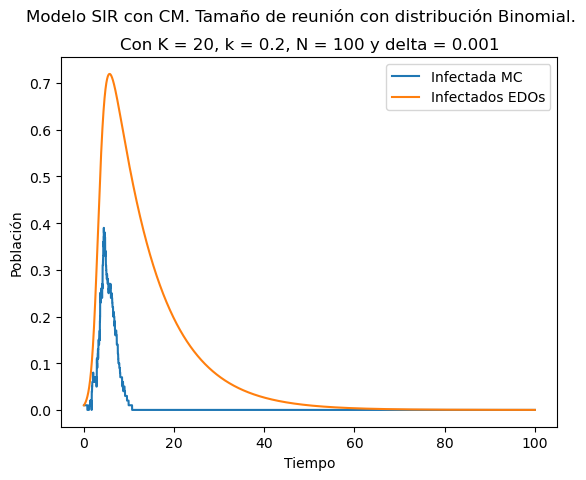

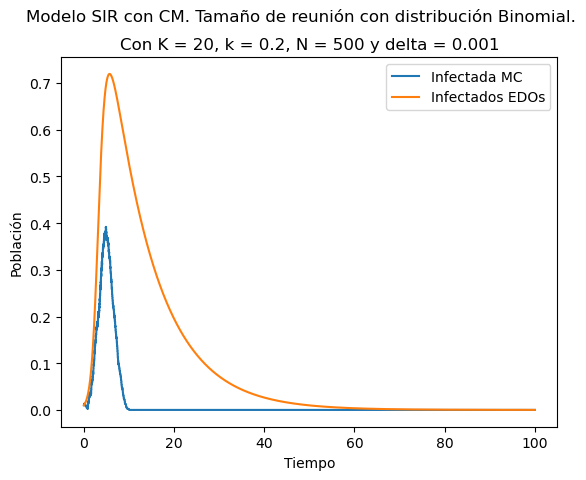

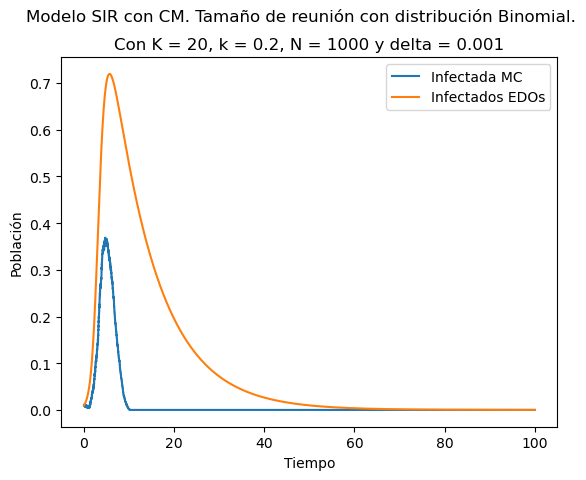

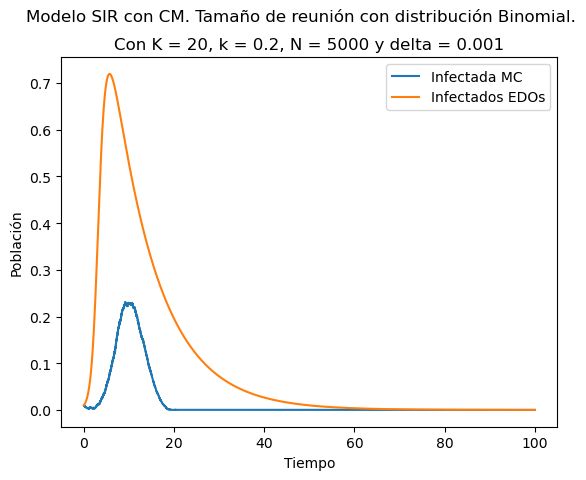

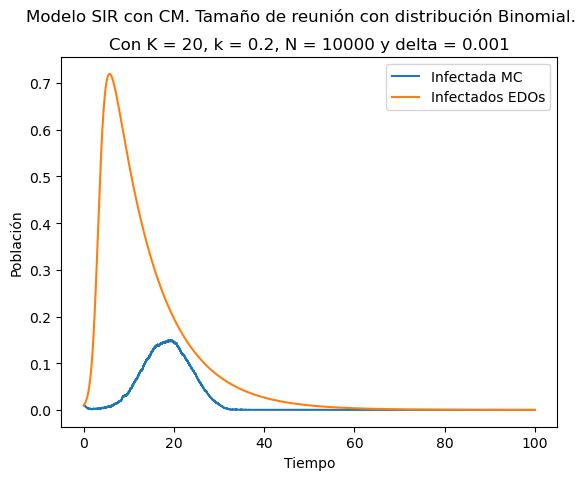

In [40]:
for i in range(len(N_list)):
    plt.figure()
    plt.suptitle('Modelo SIR con CM. Tamaño de reunión con distribución Binomial.')
    plt.title('Con K = ' +str(Distr_bin2[2])+", k = "+str(Distr_bin2[1]) + ', N = '+str(N_list[i])+ ' y delta = '+ str(deltat4))
    plt.plot(tiempo_list4[i],ZBin_list4[i][1], label = "Infectada MC")
    plt.plot(tiempo_list4[i],SolBin_list4[i][1],label='Infectados EDOs')
    plt.xlabel('Tiempo')
    plt.ylabel('Población')
    plt.legend()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3bf1084f-5255-4722-acca-d7252f921381' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>